# Multi agent non cooperative repeated experiment with mixed strategies and dynamic environment

In this setup, we will consider tasks being assigned to 4 agents:  
* 1 Requesters
* 1 dApp providers
* 1 Data providers
* 1 Computing providers

Every agent will have a randomly set ratio of failed task. This simulate more accurately real life scenario with:
* honest and experimented agents never triggering failed tasks.
* honest and beginer agents triggering by mistake a small ratio of failed tasks.
* malicious agents with mixed strategy triggering a fairly big amount of failed task.
* malicious agents with pure strategy always triggering failed tasks.

It takes only one faulty agent to fail the task.

We'll try implementing a staking system composed of two pools:  
* The stacking pool where a user initially deposit his funds.
* The slashing pool where a part of a user stake is deposited on each failed task he take parts in.

If an actor's stacking pool is empty after being slashed too many times, it is banned from the network and cannot take part in tasks anymore. The amount in the slashing pool is distributed among everyone who took part in a faulty transaction with that user.  

When taking part in a successful transaction, a small part of the slashing pool is restituted to the user as a reward.

## Basic functions

In [113]:
import math
import random
import matplotlib.pyplot as plt

In [114]:
# Constants
NUM_REQUESTERS = 100
NUM_DAPP_PROVIDERS = 100
NUM_DATA_PROVIDERS = 100
NUM_COMPUTING_PROVIDERS = 100
TOTAL_TASKS = 50000
STAKE_AMOUNT = 1000  # Amount needed to be staked in RLC

HONEST_RATIO = 0.8
MALICOUS_TRESHOLD = 0.1

SLASH_PERCENT_REQUESTER = 0.05
SLASH_PERCENT_DAPP_PROVIDER = 0.05
SLASH_PERCENT_DATA_PROVIDER = 0.05
SLASH_PERCENT_COMPUTING_PROVIDER = 0.05

REWARD_PERCENT_REQUESTER = 0.045
REWARD_PERCENT_DAPP_PROVIDER = 0.045
REWARD_PERCENT_DATA_PROVIDER = 0.045
REWARD_PERCENT_COMPUTING_PROVIDER = 0.045

In [115]:
def generate_failure_rate():
    u = random.uniform(0, 1)
    
    if u < HONEST_RATIO:
        # 80% of the time, return a failure rate between 0.0 and 0.3
        return random.uniform(0.0, MALICOUS_TRESHOLD)
    else:
        # 20% of the time, return a failure rate between 0.3 and 1.0
        return random.uniform(MALICOUS_TRESHOLD, 1.0)

# Define classes for agents
class Agent:
    def __init__(self, id, stake_pool):
        self.id = id
        self.removed = False
        self.stake_pool = stake_pool
        self.slash_pool = 0
        self.failure_rate = generate_failure_rate()
        self.failed_transactions = []
        self.failed_transaction_slash_amounts = []
        self.total_failed_transaction_amount = 0

    def print_info(self):
        return f"Agent ID: {self.id}, Stake Pool: {self.stake_pool}, Slash Pool: {self.slash_pool}, Failure Rate: {self.failure_rate}"
    
    def is_failing(self):
        return random.random() < self.failure_rate
    
    def is_malicious(self):
        return self.failure_rate > MALICOUS_TRESHOLD
    
# Define classes for transaction
class Transaction:
    def __init__(self, id, requester_id, dapp_provider_id, data_provider_id, computing_provider_id):
        self.id = id
        self.requester_id = requester_id
        self.dapp_provider_id = dapp_provider_id
        self.data_provider_id = data_provider_id
        self.computing_provider_id = computing_provider_id

    def print_info(self):
        return f"Transaction ID: {self.id}, Request ID: {self.requester_id}, dApp Provider ID: {self.dapp_provider_id}, Data Provider ID: {self.data_provider_id}, Computing Provider ID: {self.computing_provider_id}"

In [116]:
# Define a function to calculate counts, total wallets, and average wallets
def calculate_wallet_stats(requesters, dapp_providers, data_providers, computing_providers,
                                      honest_requesters_count, malicious_requesters_count,
                                      honest_dapp_providers_count, malicious_dapp_providers_count,
                                      honest_data_providers_count, malicious_data_providers_count,
                                      honest_computing_providers_count, malicious_computing_providers_count,
                                      honest_requesters_wallet, malicious_requesters_wallet,
                                      honest_dapp_providers_wallet, malicious_dapp_providers_wallet,
                                      honest_data_providers_wallet, malicious_data_providers_wallet,
                                      honest_computing_providers_wallet, malicious_computing_providers_wallet):
    # Count initial number of honest and malicious actors
    honest_requesters = sum(1 for requester in requesters.values() if not requester.is_malicious())
    malicious_requesters = sum(1 for requester in requesters.values() if requester.is_malicious())
    honest_dapp_providers = sum(1 for dapp_provider in dapp_providers.values() if not dapp_provider.is_malicious())
    malicious_dapp_providers = sum(1 for dapp_provider in dapp_providers.values() if dapp_provider.is_malicious())
    honest_data_providers = sum(1 for data_provider in data_providers.values() if not data_provider.is_malicious())
    malicious_data_providers = sum(1 for data_provider in data_providers.values() if data_provider.is_malicious())
    honest_computing_providers = sum(1 for computing_provider in computing_providers.values() if not computing_provider.is_malicious())
    malicious_computing_providers = sum(1 for computing_provider in computing_providers.values() if computing_provider.is_malicious())

    # Append counts to respective lists
    honest_requesters_count.append(honest_requesters)
    malicious_requesters_count.append(malicious_requesters)
    honest_dapp_providers_count.append(honest_dapp_providers)
    malicious_dapp_providers_count.append(malicious_dapp_providers)
    honest_data_providers_count.append(honest_data_providers)
    malicious_data_providers_count.append(malicious_data_providers)
    honest_computing_providers_count.append(honest_computing_providers)
    malicious_computing_providers_count.append(malicious_computing_providers)

    # Track total wallet amounts
    total_wallet_honest_requesters = sum(requester.stake_pool for requester in requesters.values() if not requester.is_malicious())
    total_wallet_malicious_requesters = sum(requester.stake_pool for requester in requesters.values() if requester.is_malicious())
    total_wallet_honest_dapp_providers = sum(dapp_provider.stake_pool for dapp_provider in dapp_providers.values() if not dapp_provider.is_malicious())
    total_wallet_malicious_dapp_providers = sum(dapp_provider.stake_pool for dapp_provider in dapp_providers.values() if dapp_provider.is_malicious())
    total_wallet_honest_data_providers = sum(data_provider.stake_pool for data_provider in data_providers.values() if not data_provider.is_malicious())
    total_wallet_malicious_data_providers = sum(data_provider.stake_pool for data_provider in data_providers.values() if data_provider.is_malicious())
    total_wallet_honest_computing_providers = sum(computing_provider.stake_pool for computing_provider in computing_providers.values() if not computing_provider.is_malicious())
    total_wallet_malicious_computing_providers = sum(computing_provider.stake_pool for computing_provider in computing_providers.values() if computing_provider.is_malicious())

    # Calculate average wallet amounts
    if honest_requesters > 0:
        average_wallet_honest_requesters = total_wallet_honest_requesters / honest_requesters
    else:
        average_wallet_honest_requesters = 0

    if malicious_requesters > 0:
        average_wallet_malicious_requesters = total_wallet_malicious_requesters / malicious_requesters
    else:
        average_wallet_malicious_requesters = 0

    if honest_dapp_providers > 0:
        average_wallet_honest_dapp_providers = total_wallet_honest_dapp_providers / honest_dapp_providers
    else:
        average_wallet_honest_dapp_providers = 0

    if malicious_dapp_providers > 0:
        average_wallet_malicious_dapp_providers = total_wallet_malicious_dapp_providers / malicious_dapp_providers
    else:
        average_wallet_malicious_dapp_providers = 0

    if honest_data_providers > 0:
        average_wallet_honest_data_providers = total_wallet_honest_data_providers / honest_data_providers
    else:
        average_wallet_honest_data_providers = 0

    if malicious_data_providers > 0:
        average_wallet_malicious_data_providers = total_wallet_malicious_data_providers / malicious_data_providers
    else:
        average_wallet_malicious_data_providers = 0

    if honest_computing_providers > 0:
        average_wallet_honest_computing_providers = total_wallet_honest_computing_providers / honest_computing_providers
    else:
        average_wallet_honest_computing_providers = 0

    if malicious_computing_providers > 0:
        average_wallet_malicious_computing_providers = total_wallet_malicious_computing_providers / malicious_computing_providers
    else:
        average_wallet_malicious_computing_providers = 0

    # Append average wallet amounts to lists
    honest_requesters_wallet.append(average_wallet_honest_requesters)
    malicious_requesters_wallet.append(average_wallet_malicious_requesters)
    honest_dapp_providers_wallet.append(average_wallet_honest_dapp_providers)
    malicious_dapp_providers_wallet.append(average_wallet_malicious_dapp_providers)
    honest_data_providers_wallet.append(average_wallet_honest_data_providers)
    malicious_data_providers_wallet.append(average_wallet_malicious_data_providers)
    honest_computing_providers_wallet.append(average_wallet_honest_computing_providers)
    malicious_computing_providers_wallet.append(average_wallet_malicious_computing_providers)

    # Return average wallet amounts
    return

## Multi agent bucket slashing and rewarding

BANNED REQUESTER: Agent ID: 95, Stake Pool: -104.2790275311892, Slash Pool: 1104.2790275311893, Failure Rate: 0.9430198136496564
BANNED DAPP PROVIDER: Agent ID: 61, Stake Pool: -100.033577502243, Slash Pool: 1100.033577502243, Failure Rate: 0.6056539418875422
BANNED REQUESTER: Agent ID: 16, Stake Pool: -10.17935314615896, Slash Pool: 1010.1793531461589, Failure Rate: 0.7770505576581677
BANNED COMPUTING PROVIDER: Agent ID: 67, Stake Pool: -66.29756100179294, Slash Pool: 1066.297561001793, Failure Rate: 0.7536275746984356
BANNED REQUESTER: Agent ID: 78, Stake Pool: -47.314208349799046, Slash Pool: 1047.314208349799, Failure Rate: 0.8909747102886295
BANNED DAPP PROVIDER: Agent ID: 98, Stake Pool: -60.04872630821501, Slash Pool: 1060.048726308215, Failure Rate: 0.9665215749745489
BANNED DATA PROVIDER: Agent ID: 52, Stake Pool: -97.5981210682812, Slash Pool: 1097.5981210682812, Failure Rate: 0.9164793317269826
BANNED DAPP PROVIDER: Agent ID: 76, Stake Pool: -3.5505341200210268, Slash Pool: 

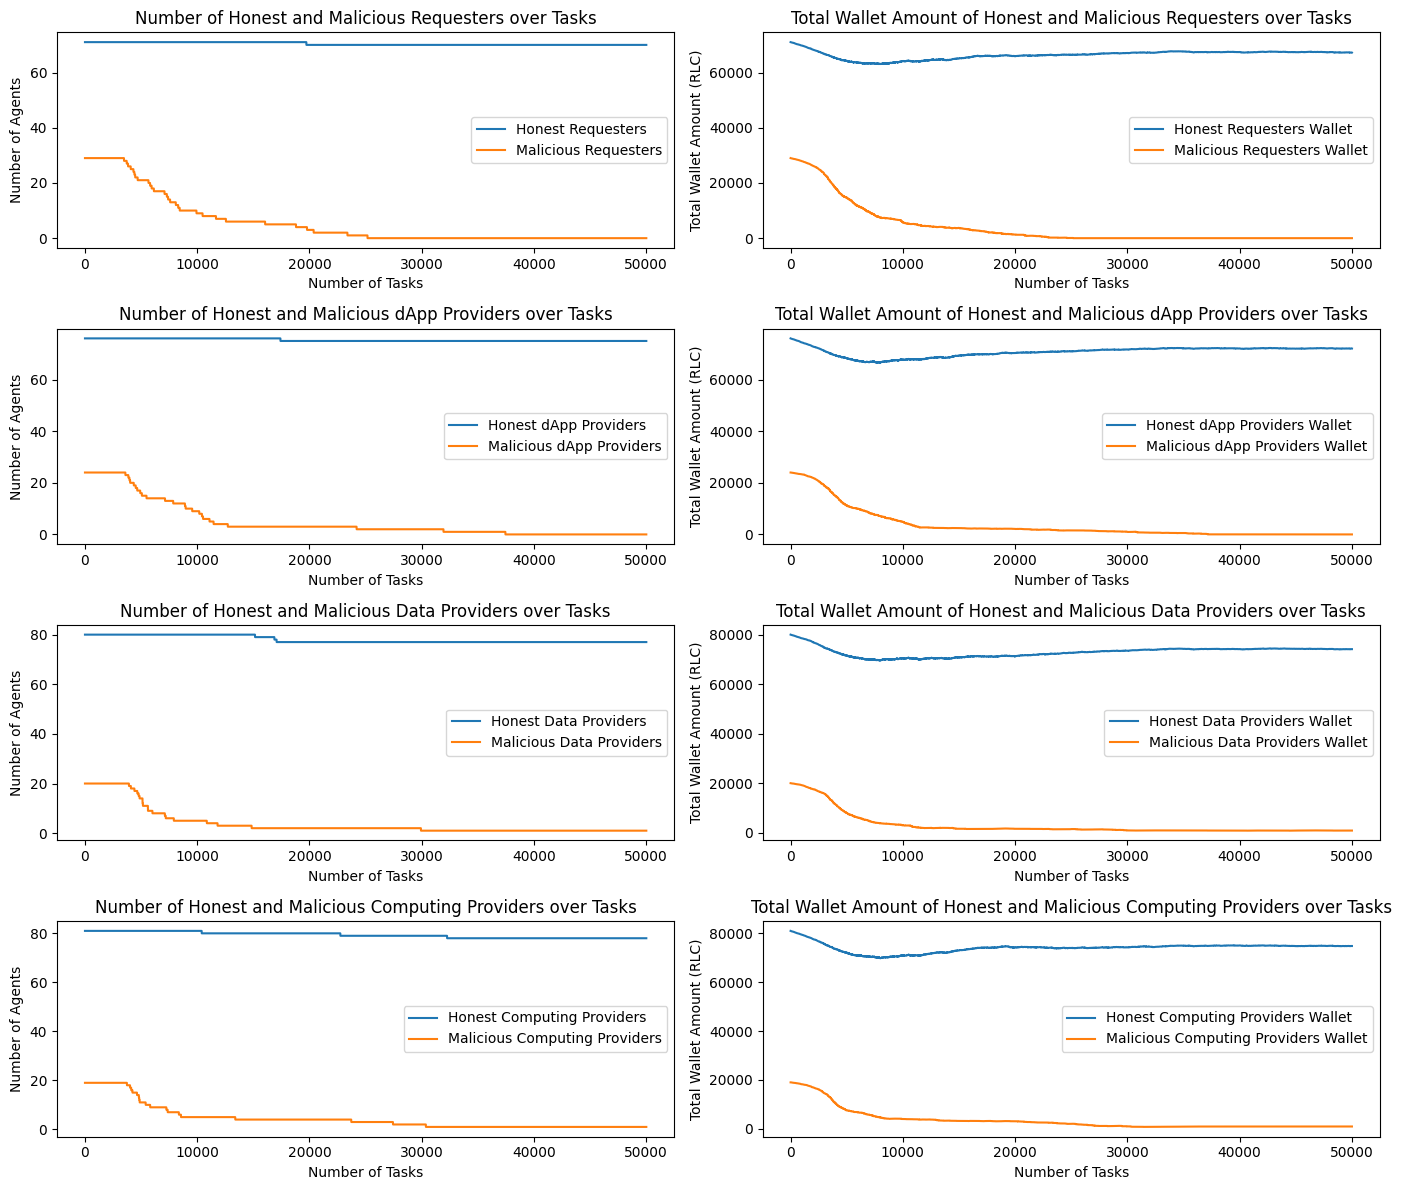

In [117]:
# Function to simulate a task round
def simulate_task_round(requesters, dapp_providers, data_providers, computing_providers, transactions):

    # Check if pools are not empty
    if not requesters or not dapp_providers or not data_providers or not computing_providers:
        return False  # No task can be performed if any pool is empty

    # Randomly assign one agent from each pool to form a task group
    requester = random.choice(requesters)
    dapp_provider = random.choice(dapp_providers)
    data_provider = random.choice(data_providers)
    computing_provider = random.choice(computing_providers)

    transaction = Transaction(len(transactions), requester.id, dapp_provider.id, data_provider.id, computing_provider.id)
    transactions.append(transaction)

    # Determine prices randomly (1 to 100 RLC)
    dapp_price = random.randint(10, 100)
    data_price = random.randint(10, 100)
    computing_price = (dapp_price + data_price) * 0.75
    total_order_price = dapp_price + data_price + computing_price


    # Check if any agent in the task group is malicious
    task_failed = any(agent.is_failing() for agent in [requester, dapp_provider, data_provider, computing_provider])

    if task_failed:
        # Calculate slashing amounts
        slash_amount_requester = ( (STAKE_AMOUNT - requester.stake_pool)/STAKE_AMOUNT + SLASH_PERCENT_REQUESTER ) * computing_price
        slash_amount_dapp_provider = ( (STAKE_AMOUNT - dapp_provider.stake_pool)/STAKE_AMOUNT + SLASH_PERCENT_DAPP_PROVIDER ) * computing_price
        slash_amount_data_provider = ( (STAKE_AMOUNT - data_provider.stake_pool)/STAKE_AMOUNT + SLASH_PERCENT_DATA_PROVIDER ) * computing_price
        # Computing provider is not slashed but incurs the cost of computation as a penalty
        slash_amount_computing_provider = ( (STAKE_AMOUNT - computing_provider.stake_pool)/STAKE_AMOUNT + SLASH_PERCENT_COMPUTING_PROVIDER ) * computing_price

        # Slash the agents
        requester.stake_pool -=  slash_amount_requester
        requester.slash_pool +=  slash_amount_requester
        dapp_provider.stake_pool -= slash_amount_dapp_provider
        dapp_provider.slash_pool += slash_amount_dapp_provider
        data_provider.stake_pool -= slash_amount_data_provider
        data_provider.slash_pool += slash_amount_data_provider
        computing_provider.stake_pool -= slash_amount_computing_provider
        computing_provider.slash_pool += slash_amount_computing_provider

        # Save amounts slashed
        requester.failed_transactions.append(transaction.id)
        requester.failed_transaction_slash_amounts.append(slash_amount_requester)
        requester.total_failed_transaction_amount += slash_amount_requester
        dapp_provider.failed_transactions.append(transaction.id)
        dapp_provider.failed_transaction_slash_amounts.append(slash_amount_dapp_provider)
        dapp_provider.total_failed_transaction_amount += slash_amount_dapp_provider
        data_provider.failed_transactions.append(transaction.id)
        data_provider.failed_transaction_slash_amounts.append(slash_amount_data_provider)
        data_provider.total_failed_transaction_amount += slash_amount_data_provider
        computing_provider.failed_transactions.append(transaction.id)
        computing_provider.failed_transaction_slash_amounts.append(slash_amount_computing_provider)
        computing_provider.total_failed_transaction_amount += slash_amount_computing_provider

        # Check if any agent's stake pool is empty
        if requester.stake_pool <= 0:
            print(f"BANNED REQUESTER: {requester.print_info()}")
            requesters.remove(requester)
            # distribute_slash_money(requester, "requester", requesters, dapp_providers, data_providers, computing_providers, transactions)
        if dapp_provider.stake_pool <= 0:
            print(f"BANNED DAPP PROVIDER: {dapp_provider.print_info()}")
            dapp_providers.remove(dapp_provider)
            # distribute_slash_money(dapp_provider, "dapp_provider", requesters, dapp_providers, data_providers, computing_providers, transactions)
        if data_provider.stake_pool <= 0:
            print(f"BANNED DATA PROVIDER: {data_provider.print_info()}")
            data_providers.remove(data_provider)
            # distribute_slash_money(data_provider, "data_provider", requesters, dapp_providers, data_providers, computing_providers, transactions)
        if computing_provider.stake_pool <= 0:
            print(f"BANNED COMPUTING PROVIDER: {computing_provider.print_info()}")
            computing_providers.remove(computing_provider)
            # distribute_slash_money(computing_provider, "computing_provider", requesters, dapp_providers, data_providers, computing_providers, transactions)
    
    else:
        # Calculate reward amount
        reward_amount_requester = ( requester.stake_pool * REWARD_PERCENT_REQUESTER ) / STAKE_AMOUNT * requester.slash_pool
        reward_amount_dapp_provider = ( dapp_provider.stake_pool * REWARD_PERCENT_DAPP_PROVIDER ) / STAKE_AMOUNT * dapp_provider.slash_pool
        reward_amount_data_provider = ( data_provider.stake_pool * REWARD_PERCENT_DATA_PROVIDER ) / STAKE_AMOUNT * data_provider.slash_pool
        # Not really possible for computing provider, to be improved
        reward_amount_computing_provider = ( computing_provider.stake_pool * REWARD_PERCENT_COMPUTING_PROVIDER ) / STAKE_AMOUNT * computing_provider.slash_pool

        # Reward the agents
        requester.stake_pool +=  reward_amount_requester
        requester.slash_pool -=  reward_amount_requester
        dapp_provider.stake_pool += reward_amount_dapp_provider
        dapp_provider.slash_pool -= reward_amount_dapp_provider
        data_provider.stake_pool += reward_amount_data_provider
        data_provider.slash_pool -= reward_amount_data_provider
        computing_provider.stake_pool += reward_amount_computing_provider
        computing_provider.slash_pool -= reward_amount_computing_provider

    # Return the result of the task (success or failure)
    return not task_failed

def distribute_slash_money(agent, agent_type, requesters, dapp_providers, data_providers, computing_providers, transactions):

    for transaction_id, amount in zip(agent.failed_transactions, agent.failed_transaction_slash_amounts):
        transaction = transactions[transaction_id]

        requester = requesters[transaction.requester_id]
        dapp_provider = dapp_providers[transaction.dapp_provider_id]
        data_provider = data_providers[transaction.data_provider_id]
        computing_provider = computing_providers[transaction.computing_provider_id]

        distribute_amount = ( amount / agent.total_failed_transaction_amount ) / 3

        if agent_type != "requester":
            requester.stake_pool += distribute_amount
            requester.stake_pool = math.floor(dapp_provider.stake_pool % (STAKE_AMOUNT + 1))

        if agent_type != "dapp_provider":
            dapp_provider.stake_pool += distribute_amount
            dapp_provider.stake_pool = math.floor(dapp_provider.stake_pool % (STAKE_AMOUNT + 1))

        if agent_type != "data_provider":
            data_provider.stake_pool += distribute_amount
            data_provider.stake_pool = math.floor(dapp_provider.stake_pool % (STAKE_AMOUNT + 1))

        if agent_type != "computing_provider":
            computing_provider.stake_pool += distribute_amount
            computing_provider.stake_pool = math.floor(dapp_provider.stake_pool % (STAKE_AMOUNT + 1))
            
    return


# Initialize pools of agents
requesters = [Agent(i, STAKE_AMOUNT) for i in range(NUM_REQUESTERS)]
dapp_providers = [Agent(i, STAKE_AMOUNT) for i in range(NUM_DAPP_PROVIDERS)]
data_providers = [Agent(i, STAKE_AMOUNT) for i in range(NUM_DATA_PROVIDERS)]
computing_providers = [Agent(i, STAKE_AMOUNT) for i in range(NUM_COMPUTING_PROVIDERS)]

# Initialize pool of transactions
transactions = []

# Track counts of honest and malicious actors over time
task_counts = list(range(1, TOTAL_TASKS + 1))
honest_requesters_count = []
malicious_requesters_count = []
honest_dapp_providers_count = []
malicious_dapp_providers_count = []
honest_data_providers_count = []
malicious_data_providers_count = []
honest_computing_providers_count = []
malicious_computing_providers_count = []

# Track wallet amounts of honest and malicious actors over time
honest_requesters_wallet = []
malicious_requesters_wallet = []
honest_dapp_providers_wallet = []
malicious_dapp_providers_wallet = []
honest_data_providers_wallet = []
malicious_data_providers_wallet = []
honest_computing_providers_wallet = []
malicious_computing_providers_wallet = []

# Simulate tasks
successful_tasks = 0
for _ in range(TOTAL_TASKS):
    # Count initial number of honest and malicious actors
    honest_requesters = sum(1 for requester in requesters if not requester.is_malicious())
    malicious_requesters = sum(1 for requester in requesters if requester.is_malicious())
    honest_dapp_providers = sum(1 for dapp_provider in dapp_providers if not dapp_provider.is_malicious())
    malicious_dapp_providers = sum(1 for dapp_provider in dapp_providers if dapp_provider.is_malicious())
    honest_data_providers = sum(1 for data_provider in data_providers if not data_provider.is_malicious())
    malicious_data_providers = sum(1 for data_provider in data_providers if data_provider.is_malicious())
    honest_computing_providers = sum(1 for computing_provider in computing_providers if not computing_provider.is_malicious())
    malicious_computing_providers = sum(1 for computing_provider in computing_providers if computing_provider.is_malicious())

    honest_requesters_count.append(honest_requesters)
    malicious_requesters_count.append(malicious_requesters)
    honest_dapp_providers_count.append(honest_dapp_providers)
    malicious_dapp_providers_count.append(malicious_dapp_providers)
    honest_data_providers_count.append(honest_data_providers)
    malicious_data_providers_count.append(malicious_data_providers)
    honest_computing_providers_count.append(honest_computing_providers)
    malicious_computing_providers_count.append(malicious_computing_providers)

    # Track total wallet amounts
    total_wallet_honest_requesters = sum(requester.stake_pool for requester in requesters if not requester.is_malicious())
    total_wallet_malicious_requesters = sum(requester.stake_pool for requester in requesters if requester.is_malicious())
    total_wallet_honest_dapp_providers = sum(dapp_provider.stake_pool for dapp_provider in dapp_providers if not dapp_provider.is_malicious())
    total_wallet_malicious_dapp_providers = sum(dapp_provider.stake_pool for dapp_provider in dapp_providers if dapp_provider.is_malicious())
    total_wallet_honest_data_providers = sum(data_provider.stake_pool for data_provider in data_providers if not data_provider.is_malicious())
    total_wallet_malicious_data_providers = sum(data_provider.stake_pool for data_provider in data_providers if data_provider.is_malicious())
    total_wallet_honest_computing_providers = sum(computing_provider.stake_pool for computing_provider in computing_providers if not computing_provider.is_malicious())
    total_wallet_malicious_computing_providers = sum(computing_provider.stake_pool for computing_provider in computing_providers if computing_provider.is_malicious())

    honest_requesters_wallet.append(total_wallet_honest_requesters)
    malicious_requesters_wallet.append(total_wallet_malicious_requesters)
    honest_dapp_providers_wallet.append(total_wallet_honest_dapp_providers)
    malicious_dapp_providers_wallet.append(total_wallet_malicious_dapp_providers)
    honest_data_providers_wallet.append(total_wallet_honest_data_providers)
    malicious_data_providers_wallet.append(total_wallet_malicious_data_providers)
    honest_computing_providers_wallet.append(total_wallet_honest_computing_providers)
    malicious_computing_providers_wallet.append(total_wallet_malicious_computing_providers)

    if simulate_task_round(requesters, dapp_providers, data_providers, computing_providers, transactions):
        successful_tasks += 1

# Print results
print(f"Total tasks: {TOTAL_TASKS}")
print(f"Successful tasks: {successful_tasks}")
print(f"Failed tasks: {TOTAL_TASKS - successful_tasks}")

print("Remaining agents:")
print(f"Requesters: {len(requesters)}")
print(f"dApp Providers: {len(dapp_providers)}")
print(f"Data Providers: {len(data_providers)}")
print(f"Computing Providers: {len(computing_providers)}")

# Plot results
plt.figure(figsize=(14, 12))

plt.subplot(421)
plt.plot(task_counts, honest_requesters_count, label='Honest Requesters')
plt.plot(task_counts, malicious_requesters_count, label='Malicious Requesters')
plt.title('Number of Honest and Malicious Requesters over Tasks')
plt.xlabel('Number of Tasks')
plt.ylabel('Number of Agents')
plt.legend()

plt.subplot(422)
plt.plot(task_counts, honest_requesters_wallet, label='Honest Requesters Wallet')
plt.plot(task_counts, malicious_requesters_wallet, label='Malicious Requesters Wallet')
plt.title('Total Wallet Amount of Honest and Malicious Requesters over Tasks')
plt.xlabel('Number of Tasks')
plt.ylabel('Total Wallet Amount (RLC)')
plt.legend()

plt.subplot(423)
plt.plot(task_counts, honest_dapp_providers_count, label='Honest dApp Providers')
plt.plot(task_counts, malicious_dapp_providers_count, label='Malicious dApp Providers')
plt.title('Number of Honest and Malicious dApp Providers over Tasks')
plt.xlabel('Number of Tasks')
plt.ylabel('Number of Agents')
plt.legend()

plt.subplot(424)
plt.plot(task_counts, honest_dapp_providers_wallet, label='Honest dApp Providers Wallet')
plt.plot(task_counts, malicious_dapp_providers_wallet, label='Malicious dApp Providers Wallet')
plt.title('Total Wallet Amount of Honest and Malicious dApp Providers over Tasks')
plt.xlabel('Number of Tasks')
plt.ylabel('Total Wallet Amount (RLC)')
plt.legend()

plt.subplot(425)
plt.plot(task_counts, honest_data_providers_count, label='Honest Data Providers')
plt.plot(task_counts, malicious_data_providers_count, label='Malicious Data Providers')
plt.title('Number of Honest and Malicious Data Providers over Tasks')
plt.xlabel('Number of Tasks')
plt.ylabel('Number of Agents')
plt.legend()

plt.subplot(426)
plt.plot(task_counts, honest_data_providers_wallet, label='Honest Data Providers Wallet')
plt.plot(task_counts, malicious_data_providers_wallet, label='Malicious Data Providers Wallet')
plt.title('Total Wallet Amount of Honest and Malicious Data Providers over Tasks')
plt.xlabel('Number of Tasks')
plt.ylabel('Total Wallet Amount (RLC)')
plt.legend()

plt.subplot(427)
plt.plot(task_counts, honest_computing_providers_count, label='Honest Computing Providers')
plt.plot(task_counts, malicious_computing_providers_count, label='Malicious Computing Providers')
plt.title('Number of Honest and Malicious Computing Providers over Tasks')
plt.xlabel('Number of Tasks')
plt.ylabel('Number of Agents')
plt.legend()

plt.subplot(428)
plt.plot(task_counts, honest_computing_providers_wallet, label='Honest Computing Providers Wallet')
plt.plot(task_counts, malicious_computing_providers_wallet, label='Malicious Computing Providers Wallet')
plt.title('Total Wallet Amount of Honest and Malicious Computing Providers over Tasks')
plt.xlabel('Number of Tasks')
plt.ylabel('Total Wallet Amount (RLC)')
plt.legend()

plt.tight_layout()
plt.show()

BANNED DAPP PROVIDER: Agent ID: 60, Stake Pool: -65.81652481495595, Slash Pool: 1065.8165248149558, Failure Rate: 0.9330851529492655
BANNED COMPUTING PROVIDER: Agent ID: 38, Stake Pool: -23.54860015955002, Slash Pool: 1023.5486001595494, Failure Rate: 0.9098849730081768
BANNED DATA PROVIDER: Agent ID: 59, Stake Pool: -66.30579487617673, Slash Pool: 1066.3057948761764, Failure Rate: 0.940710885515442
BANNED DATA PROVIDER: Agent ID: 68, Stake Pool: -73.73793349030484, Slash Pool: 1073.7379334903044, Failure Rate: 0.7045019954950889
BANNED COMPUTING PROVIDER: Agent ID: 23, Stake Pool: -39.03111218213441, Slash Pool: 1039.0311121821344, Failure Rate: 0.5459347618445815
BANNED DAPP PROVIDER: Agent ID: 99, Stake Pool: -20.110592177251963, Slash Pool: 1019.3603724118981, Failure Rate: 0.7162103926516201
BANNED COMPUTING PROVIDER: Agent ID: 54, Stake Pool: -60.466499999999996, Slash Pool: 1059.5458449960997, Failure Rate: 0.8422335875006212
BANNED REQUESTER: Agent ID: 74, Stake Pool: -58.51915

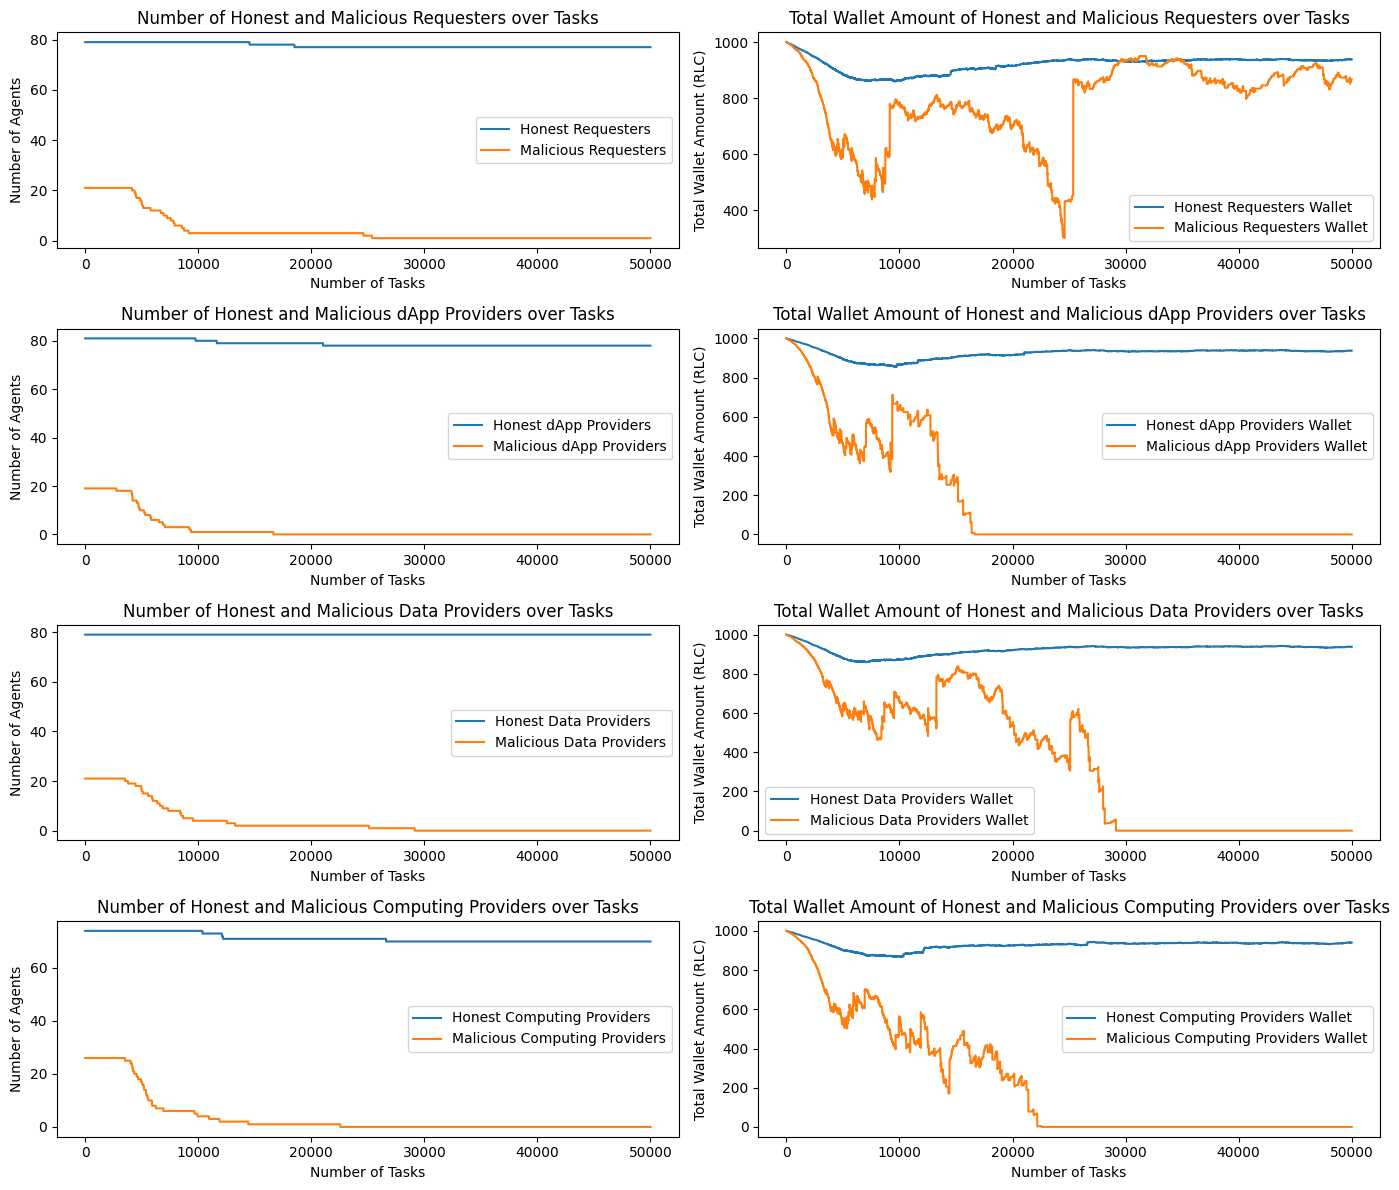

In [118]:
# Function to simulate a task round
def simulate_task_round(requesters, dapp_providers, data_providers, computing_providers, transactions):

    # Check if pools are not empty
    if not requesters or not dapp_providers or not data_providers or not computing_providers:
        return False  # No task can be performed if any pool is empty

    # Randomly choose agents from each dictionary
    requester = random.choice(list(requesters.values()))
    dapp_provider = random.choice(list(dapp_providers.values()))
    data_provider = random.choice(list(data_providers.values()))
    computing_provider = random.choice(list(computing_providers.values()))

    transaction = Transaction(len(transactions), requester.id, dapp_provider.id, data_provider.id, computing_provider.id)
    transactions.append(transaction)

    # Determine prices randomly (1 to 100 RLC)
    dapp_price = random.randint(10, 100)
    data_price = random.randint(10, 100)
    computing_price = (dapp_price + data_price) * 0.75
    total_order_price = dapp_price + data_price + computing_price


    # Check if any agent in the task group is malicious
    task_failed = any(agent.is_failing() for agent in [requester, dapp_provider, data_provider, computing_provider])

    if task_failed:
        # Calculate slashing amounts
        slash_amount_requester = ( (STAKE_AMOUNT - requester.stake_pool)/STAKE_AMOUNT + SLASH_PERCENT_REQUESTER ) * computing_price
        slash_amount_dapp_provider = ( (STAKE_AMOUNT - dapp_provider.stake_pool)/STAKE_AMOUNT + SLASH_PERCENT_DAPP_PROVIDER ) * computing_price
        slash_amount_data_provider = ( (STAKE_AMOUNT - data_provider.stake_pool)/STAKE_AMOUNT + SLASH_PERCENT_DATA_PROVIDER ) * computing_price
        # Computing provider is not slashed but incurs the cost of computation as a penalty
        slash_amount_computing_provider = ( (STAKE_AMOUNT - computing_provider.stake_pool)/STAKE_AMOUNT + SLASH_PERCENT_COMPUTING_PROVIDER ) * computing_price

        # Slash the agents
        requester.stake_pool -=  slash_amount_requester
        requester.slash_pool +=  slash_amount_requester
        dapp_provider.stake_pool -= slash_amount_dapp_provider
        dapp_provider.slash_pool += slash_amount_dapp_provider
        data_provider.stake_pool -= slash_amount_data_provider
        data_provider.slash_pool += slash_amount_data_provider
        computing_provider.stake_pool -= slash_amount_computing_provider
        computing_provider.slash_pool += slash_amount_computing_provider

        # Save amounts slashed
        requester.failed_transactions.append(transaction.id)
        requester.failed_transaction_slash_amounts.append(slash_amount_requester)
        requester.total_failed_transaction_amount += slash_amount_requester
        dapp_provider.failed_transactions.append(transaction.id)
        dapp_provider.failed_transaction_slash_amounts.append(slash_amount_dapp_provider)
        dapp_provider.total_failed_transaction_amount += slash_amount_dapp_provider
        data_provider.failed_transactions.append(transaction.id)
        data_provider.failed_transaction_slash_amounts.append(slash_amount_data_provider)
        data_provider.total_failed_transaction_amount += slash_amount_data_provider
        computing_provider.failed_transactions.append(transaction.id)
        computing_provider.failed_transaction_slash_amounts.append(slash_amount_computing_provider)
        computing_provider.total_failed_transaction_amount += slash_amount_computing_provider

        # Check if any agent's stake pool is empty
        if requester.stake_pool <= 0:
            print(f"BANNED REQUESTER: {requester.print_info()}")
            # requesters.remove(requester)
            del requesters[requester.id]
            distribute_slash_money(requester, requesters, dapp_providers, data_providers, computing_providers, transactions)
        if dapp_provider.stake_pool <= 0:
            print(f"BANNED DAPP PROVIDER: {dapp_provider.print_info()}")
            # dapp_providers.remove(dapp_provider)
            del dapp_providers[dapp_provider.id]
            distribute_slash_money(dapp_provider, requesters, dapp_providers, data_providers, computing_providers, transactions)
        if data_provider.stake_pool <= 0:
            print(f"BANNED DATA PROVIDER: {data_provider.print_info()}")
            # data_providers.remove(data_provider)
            del data_providers[data_provider.id]
            distribute_slash_money(data_provider, requesters, dapp_providers, data_providers, computing_providers, transactions)
        if computing_provider.stake_pool <= 0:
            print(f"BANNED COMPUTING PROVIDER: {computing_provider.print_info()}")
            # computing_providers.remove(computing_provider)
            del computing_providers[computing_provider.id]
            distribute_slash_money(computing_provider, requesters, dapp_providers, data_providers, computing_providers, transactions)
    
    else:
        # Calculate reward amount
        reward_amount_requester = ( requester.stake_pool * REWARD_PERCENT_REQUESTER ) / STAKE_AMOUNT * requester.slash_pool
        reward_amount_dapp_provider = ( dapp_provider.stake_pool * REWARD_PERCENT_DAPP_PROVIDER ) / STAKE_AMOUNT * dapp_provider.slash_pool
        reward_amount_data_provider = ( data_provider.stake_pool * REWARD_PERCENT_DATA_PROVIDER ) / STAKE_AMOUNT * data_provider.slash_pool
        # Not really possible for computing provider, to be improved
        reward_amount_computing_provider = ( computing_provider.stake_pool * REWARD_PERCENT_COMPUTING_PROVIDER ) / STAKE_AMOUNT * computing_provider.slash_pool

        # Reward the agents
        requester.stake_pool +=  reward_amount_requester
        requester.slash_pool -=  reward_amount_requester
        dapp_provider.stake_pool += reward_amount_dapp_provider
        dapp_provider.slash_pool -= reward_amount_dapp_provider
        data_provider.stake_pool += reward_amount_data_provider
        data_provider.slash_pool -= reward_amount_data_provider
        computing_provider.stake_pool += reward_amount_computing_provider
        computing_provider.slash_pool -= reward_amount_computing_provider

    # Return the result of the task (success or failure)
    return not task_failed

def distribute_slash_money(agent, requesters, dapp_providers, data_providers, computing_providers, transactions):

    for transaction_id, amount in zip(agent.failed_transactions, agent.failed_transaction_slash_amounts):
        transaction = transactions[transaction_id]
        number_agents = 0

        if transaction.requester_id in requesters:
            requester = requesters[transaction.requester_id]
            number_agents += 1
        if transaction.dapp_provider_id in dapp_providers:
            dapp_provider = dapp_providers[transaction.dapp_provider_id]
            number_agents += 1
        if transaction.data_provider_id in data_providers:
            data_provider = data_providers[transaction.data_provider_id]
            number_agents += 1
        if transaction.computing_provider_id in computing_providers:
            computing_provider = computing_providers[transaction.computing_provider_id]
            number_agents += 1

        if number_agents > 0:
            distribute_amount = ( amount / agent.total_failed_transaction_amount ) / number_agents
        else:
            distribute_amount = 0

        if transaction.requester_id in requesters:
            requester.stake_pool += distribute_amount
            requester.stake_pool = math.floor(requester.stake_pool % (STAKE_AMOUNT + 1))
        if transaction.dapp_provider_id in dapp_providers:
            dapp_provider.stake_pool += distribute_amount
            dapp_provider.stake_pool = math.floor(dapp_provider.stake_pool % (STAKE_AMOUNT + 1))
        if transaction.data_provider_id in data_providers:
            data_provider.stake_pool += distribute_amount
            data_provider.stake_pool = math.floor(data_provider.stake_pool % (STAKE_AMOUNT + 1))
        if transaction.computing_provider_id in computing_providers:
            computing_provider.stake_pool += distribute_amount
            computing_provider.stake_pool = math.floor(computing_provider.stake_pool % (STAKE_AMOUNT + 1))            
            
    return


# Initialize pools of agents
requesters = {i: Agent(i, STAKE_AMOUNT) for i in range(NUM_REQUESTERS)}
dapp_providers = {i: Agent(i, STAKE_AMOUNT) for i in range(NUM_DAPP_PROVIDERS)}
data_providers = {i: Agent(i, STAKE_AMOUNT) for i in range(NUM_DATA_PROVIDERS)}
computing_providers = {i: Agent(i, STAKE_AMOUNT) for i in range(NUM_COMPUTING_PROVIDERS)}

# Initialize pool of transactions
transactions = []

# Track counts of honest and malicious actors over time
task_counts = list(range(1, TOTAL_TASKS + 1))
honest_requesters_count = []
malicious_requesters_count = []
honest_dapp_providers_count = []
malicious_dapp_providers_count = []
honest_data_providers_count = []
malicious_data_providers_count = []
honest_computing_providers_count = []
malicious_computing_providers_count = []

# Track wallet amounts of honest and malicious actors over time
honest_requesters_wallet = []
malicious_requesters_wallet = []
honest_dapp_providers_wallet = []
malicious_dapp_providers_wallet = []
honest_data_providers_wallet = []
malicious_data_providers_wallet = []
honest_computing_providers_wallet = []
malicious_computing_providers_wallet = []

# Simulate tasks
successful_tasks = 0
for _ in range(TOTAL_TASKS):
    # Calculate counts, total wallets, and average wallets
    calculate_wallet_stats(requesters, dapp_providers, data_providers, computing_providers,
                                                                            honest_requesters_count, malicious_requesters_count,
                                                                            honest_dapp_providers_count, malicious_dapp_providers_count,
                                                                            honest_data_providers_count, malicious_data_providers_count,
                                                                            honest_computing_providers_count, malicious_computing_providers_count,
                                                                            honest_requesters_wallet, malicious_requesters_wallet,
                                                                            honest_dapp_providers_wallet, malicious_dapp_providers_wallet,
                                                                            honest_data_providers_wallet, malicious_data_providers_wallet,
                                                                            honest_computing_providers_wallet, malicious_computing_providers_wallet)

    if simulate_task_round(requesters, dapp_providers, data_providers, computing_providers, transactions):
        successful_tasks += 1

# Print results
print(f"Total tasks: {TOTAL_TASKS}")
print(f"Successful tasks: {successful_tasks}")
print(f"Failed tasks: {TOTAL_TASKS - successful_tasks}")

print("Remaining agents:")
print(f"Requesters: {len(requesters)}")
print(f"dApp Providers: {len(dapp_providers)}")
print(f"Data Providers: {len(data_providers)}")
print(f"Computing Providers: {len(computing_providers)}")

# Plot results
plt.figure(figsize=(14, 12))

plt.subplot(421)
plt.plot(task_counts, honest_requesters_count, label='Honest Requesters')
plt.plot(task_counts, malicious_requesters_count, label='Malicious Requesters')
plt.title('Number of Honest and Malicious Requesters over Tasks')
plt.xlabel('Number of Tasks')
plt.ylabel('Number of Agents')
plt.legend()

plt.subplot(422)
plt.plot(task_counts, honest_requesters_wallet, label='Honest Requesters Wallet')
plt.plot(task_counts, malicious_requesters_wallet, label='Malicious Requesters Wallet')
plt.title('Total Wallet Amount of Honest and Malicious Requesters over Tasks')
plt.xlabel('Number of Tasks')
plt.ylabel('Total Wallet Amount (RLC)')
plt.legend()

plt.subplot(423)
plt.plot(task_counts, honest_dapp_providers_count, label='Honest dApp Providers')
plt.plot(task_counts, malicious_dapp_providers_count, label='Malicious dApp Providers')
plt.title('Number of Honest and Malicious dApp Providers over Tasks')
plt.xlabel('Number of Tasks')
plt.ylabel('Number of Agents')
plt.legend()

plt.subplot(424)
plt.plot(task_counts, honest_dapp_providers_wallet, label='Honest dApp Providers Wallet')
plt.plot(task_counts, malicious_dapp_providers_wallet, label='Malicious dApp Providers Wallet')
plt.title('Total Wallet Amount of Honest and Malicious dApp Providers over Tasks')
plt.xlabel('Number of Tasks')
plt.ylabel('Total Wallet Amount (RLC)')
plt.legend()

plt.subplot(425)
plt.plot(task_counts, honest_data_providers_count, label='Honest Data Providers')
plt.plot(task_counts, malicious_data_providers_count, label='Malicious Data Providers')
plt.title('Number of Honest and Malicious Data Providers over Tasks')
plt.xlabel('Number of Tasks')
plt.ylabel('Number of Agents')
plt.legend()

plt.subplot(426)
plt.plot(task_counts, honest_data_providers_wallet, label='Honest Data Providers Wallet')
plt.plot(task_counts, malicious_data_providers_wallet, label='Malicious Data Providers Wallet')
plt.title('Total Wallet Amount of Honest and Malicious Data Providers over Tasks')
plt.xlabel('Number of Tasks')
plt.ylabel('Total Wallet Amount (RLC)')
plt.legend()

plt.subplot(427)
plt.plot(task_counts, honest_computing_providers_count, label='Honest Computing Providers')
plt.plot(task_counts, malicious_computing_providers_count, label='Malicious Computing Providers')
plt.title('Number of Honest and Malicious Computing Providers over Tasks')
plt.xlabel('Number of Tasks')
plt.ylabel('Number of Agents')
plt.legend()

plt.subplot(428)
plt.plot(task_counts, honest_computing_providers_wallet, label='Honest Computing Providers Wallet')
plt.plot(task_counts, malicious_computing_providers_wallet, label='Malicious Computing Providers Wallet')
plt.title('Total Wallet Amount of Honest and Malicious Computing Providers over Tasks')
plt.xlabel('Number of Tasks')
plt.ylabel('Total Wallet Amount (RLC)')
plt.legend()

plt.tight_layout()
plt.show()